In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Define a matrix, mask and noise
p = 0.75
rank = 1

n = 40

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])

In [32]:
def minimize_singular_value(sing_val_index):

    starting_point = np.copy(original)

    boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
    starting_point[boolMask] = 0

    prev_norm = np.linalg.norm(starting_point,'nuc')

    current_point = starting_point

    def obj_func(m, vec):
        u, s, vh = np.linalg.svd(m)
        index = np.argmax(np.dot(vec, u))

        return s[index]

    def comp_grad(of, m, vec):
        """ Computes gradient that maximizes the objective function """
        epsilon = 1e-3

        grad = np.zeros([n,n])

        for i in range(n):
            for j in range(n):
                if boolMask[i,j]:
                    diff = np.zeros([n,n])
                    diff[i,j] = epsilon
                    grad[i,j] = (of(m + diff, vec) - of(m - diff, vec))/(2*epsilon)

        return grad


    u, s, vh = np.linalg.svd(current_point)
    vec = u[:,sing_val_index]

    sing_val_log = []
    distances_log = []
    
    for i in range(2000):
        u, s, vh = np.linalg.svd(current_point)
        index = np.argmax(np.dot(vec, u))
        vec = u[:,index]

        print(i, index, s[index], np.linalg.norm(current_point-original,'fro'))
        sing_val_log.append(s[index])
        distances_log.append(np.linalg.norm(current_point-original,'fro'))
        current_point = current_point - 0.1*comp_grad(obj_func, current_point, vec)
    
    return current_point, sing_val_log, distances_log

### A bit of mess

In [33]:
starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

current_point = starting_point

def obj_func(m, vec):
    u, s, vh = np.linalg.svd(m)
    index = np.argmax(np.dot(vec, u))

    return s[index]

def comp_grad(of, m, vec):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3

    grad = np.zeros([n,n])

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad[i,j] = (of(m + diff, vec) - of(m - diff, vec))/(2*epsilon)

    return grad

def line_search(point, grad, obj_func, vec, s = 0.01, threshold = 1e-10):
    """ Finds a maximum step size that maximizes the descent (since computing gradient is hard) """

    choice = point - grad * s
    while obj_func(choice, vec) > obj_func(point, vec):
        s = s / 2
        choice = point - grad * s

    initial_s = s

    while True:
        left = choice + grad * s/2
        right = point - grad * s/2

        s = s / 2
        if obj_func(left, vec) < obj_func(right, vec):
            choice = left
        else:
            choice = right

        if np.abs(obj_func(left,vec) - obj_func(right, vec)) < threshold:
            break

    return choice

sing_val_log = []
distances_log = []

for sing_val_index in range(3,0,-1):

    print("\n")
    print("##################")
    print("Optimizing", sing_val_index)
    print("##################")
    print("\n")
    
    u, s, vh = np.linalg.svd(current_point)
    vec = u[:,sing_val_index]

    i = 0
    while obj_func(current_point, vec) > 0.00001:
        i = i + 1
        u, s, vh = np.linalg.svd(current_point)
        index = np.argmax(np.dot(vec, u))
        vec = u[:,index]

        print(i, index, s[index], np.linalg.norm(current_point-original,'fro'))
        sing_val_log.append(s[index])
        distances_log.append(np.linalg.norm(current_point-original,'fro'))
        #current_point = current_point - 0.0001*comp_grad(obj_func, current_point, vec)
        grad = comp_grad(obj_func, current_point, vec)
        current_point = line_search(current_point, grad, obj_func, vec)
    



##################
Optimizing 3
##################


1 3 5.401658357089332 17.1560386997971
2 3 5.399540368309205 17.154458641411093
3 3 5.397422991690538 17.152879078118467
4 3 5.395306229154046 17.15130000979111
5 3 5.393190082610833 17.149721436300553
6 3 5.391074553962549 17.148143357518133
7 3 5.3889596451013375 17.146565773314823
8 3 5.386845357910008 17.14498868356142
9 3 5.3847316942621015 17.143412088128446
10 3 5.382618656021921 17.141835986886086
11 3 5.380506245044711 17.140260379704365
12 3 5.378394463176574 17.138685266452914
13 3 5.376283312254666 17.13711064700113
14 3 5.374172794107257 17.13553652121821
15 3 5.372062910553737 17.133962888973024
16 3 5.369953663404755 17.13238975013417
17 3 5.367845054462264 17.130817104569978
18 3 5.365737085519596 17.129244952148554
19 3 5.363629758361513 17.127673292737644
20 3 5.361523074764325 17.126102126204838
21 3 5.359417036495862 17.124531452417354
22 3 5.357311645315662 17.122961271242186
23 3 5.355206902974965 17.121391582

195 3 5.004111112732776 16.858606951458356
196 3 5.002139593062412 16.857120217113263
197 3 5.000168941672737 16.855633947930894


KeyboardInterrupt: 

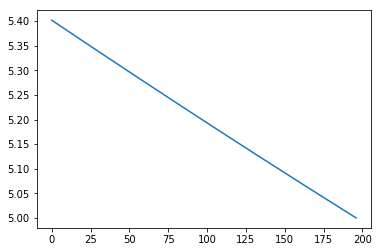

In [34]:
plt.plot(sing_val_log)

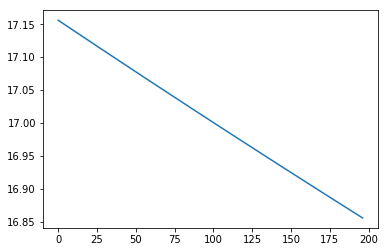

In [35]:
plt.plot(distances_log)

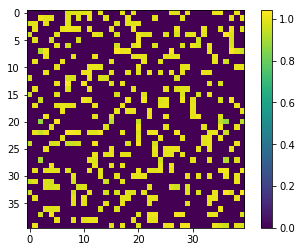

In [36]:
plt.imshow((original-current_point)/original)
plt.colorbar()

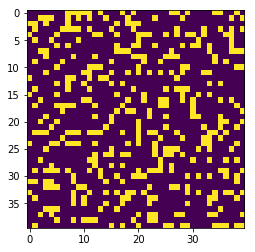

In [38]:
plt.imshow(~mask)